In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

import copy

#for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

from scipy.ndimage import gaussian_filter

import os
import sys
# sys.path.append(os.path.join(os.path.dirname(__file__)))
# sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from CircularLinearReg.core import (
    cl_corr, 
    circular_mean_resultant_vector_length, 
    cl_regression, 
)

from plotting_utils import (
    plot_circular_histogram, 
    plot_expected_theta_sweep, 
    robust_spline_interpolation, 
    plot_paired_boxplot, 
    plot_circular_histogram_with_values, 
)

from model_utils import (
    run_model, 
)

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

/Users/changminyu/miniconda3/envs/cyu_arm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# demo
goal_loc = [0.5 * np.pi, 0.5 * np.pi]
total_time = 0.5
dt = 0.01
move_prob = 0.5
drift_factor = 0.0
velocity = 20.0
rotation_speed = np.pi / 50
stick_length = 0.2

v0 = bm.pi / 1000
noise_strength = 0.0
phase_offset = 1.5
theta_hd_modulation = 0.4
theta_gc_modulation = 0.8
top_down_modulation = 4.0

num_hd = 100
tau_hd = 10.0
tau_v_hd = 100.0
mbar_hd = 10.0
a_hd = 0.4
A_hd = 3.0
a_hd_goal = 0.4
A_hd_goal = 3.0
J0_hd = 4.0

top_down = True

num_pc = 50
tau_pc = 10.0
tau_v_pc = 100.0
mbar_pc = 1.0
a_pc = 0.5
A_pc = 5.0
A_td_pc = 5.0
J0_pc = 10.0
g = 1000.0

time_chunk = 50000
device = "cpu"

default_params = {
    "goal_loc": goal_loc,
    "total_time": total_time,
    "dt": dt,
    "move_prob": move_prob,
    "drift_factor": drift_factor,
    "velocity": velocity,
    "rotation_speed": rotation_speed,
    "stick_length": stick_length,
    "v0": v0,
    "noise_strength": noise_strength,
    "phase_offset": phase_offset,
    "theta_hd_modulation": theta_hd_modulation,
    "theta_gc_modulation": theta_gc_modulation,
    "top_down_modulation": top_down_modulation,
    "num_hd": num_hd,
    "tau_hd": tau_hd,
    "tau_v_hd": tau_v_hd,
    "mbar_hd": mbar_hd,
    "a_hd": a_hd,
    "A_hd": A_hd,
    "a_hd_goal": a_hd_goal,
    "A_hd_goal": A_hd_goal,
    "J0_hd": J0_hd,
    "top_down": top_down,
    "num_pc": num_pc,
    "tau_pc": tau_pc,
    "tau_v_pc": tau_v_pc,
    "mbar_pc": mbar_pc,
    "a_pc": a_pc,
    "A_pc": A_pc,
    "A_td_pc": A_td_pc,
    "J0_pc": J0_pc,
    "g": g,
    "time_chunk": time_chunk,
    "device": device
}

In [15]:
(
    HD_net_with_td, 
    PC_net_with_td,
    animal_centre_all_with_td,
    animal_head_loc_all_with_td,
    hd_all_with_td,
    md_all_with_td,
    gd_all_with_td,
    speed_all_with_td,
    pc_activity_with_td,
    hd_activity_with_td,
    pc_bump_center_with_td,
    hd_bump_center_with_td,
    t_upsampled_with_td,
    theta_phase_with_td,
    theta_rhythm_with_td,
    rotation_phase_with_td,
    rotation_direction_flag_all_with_td,
) = run_model(
    **default_params, 
)

default_params_no_td = copy.deepcopy(default_params)
default_params_no_td["top_down"] = False

(
    HD_net_no_td, 
    PC_net_no_td,
    animal_centre_all_no_td,
    animal_head_loc_all_no_td,
    hd_all_no_td,
    md_all_no_td,
    gd_all_no_td,
    speed_all_no_td,
    pc_activity_no_td,
    hd_activity_no_td,
    pc_bump_center_no_td,
    hd_bump_center_no_td,
    t_upsampled_no_td,
    theta_phase_no_td,
    theta_rhythm_no_td,
    rotation_phase_no_td,
    rotation_direction_flag_all_no_td, 
) = run_model(
    **default_params_no_td, 
)

Start running simulation.
Simnulation progress: 0.0%
Simulation completed.
Start running simulation.
Simnulation progress: 0.0%
Simulation completed.


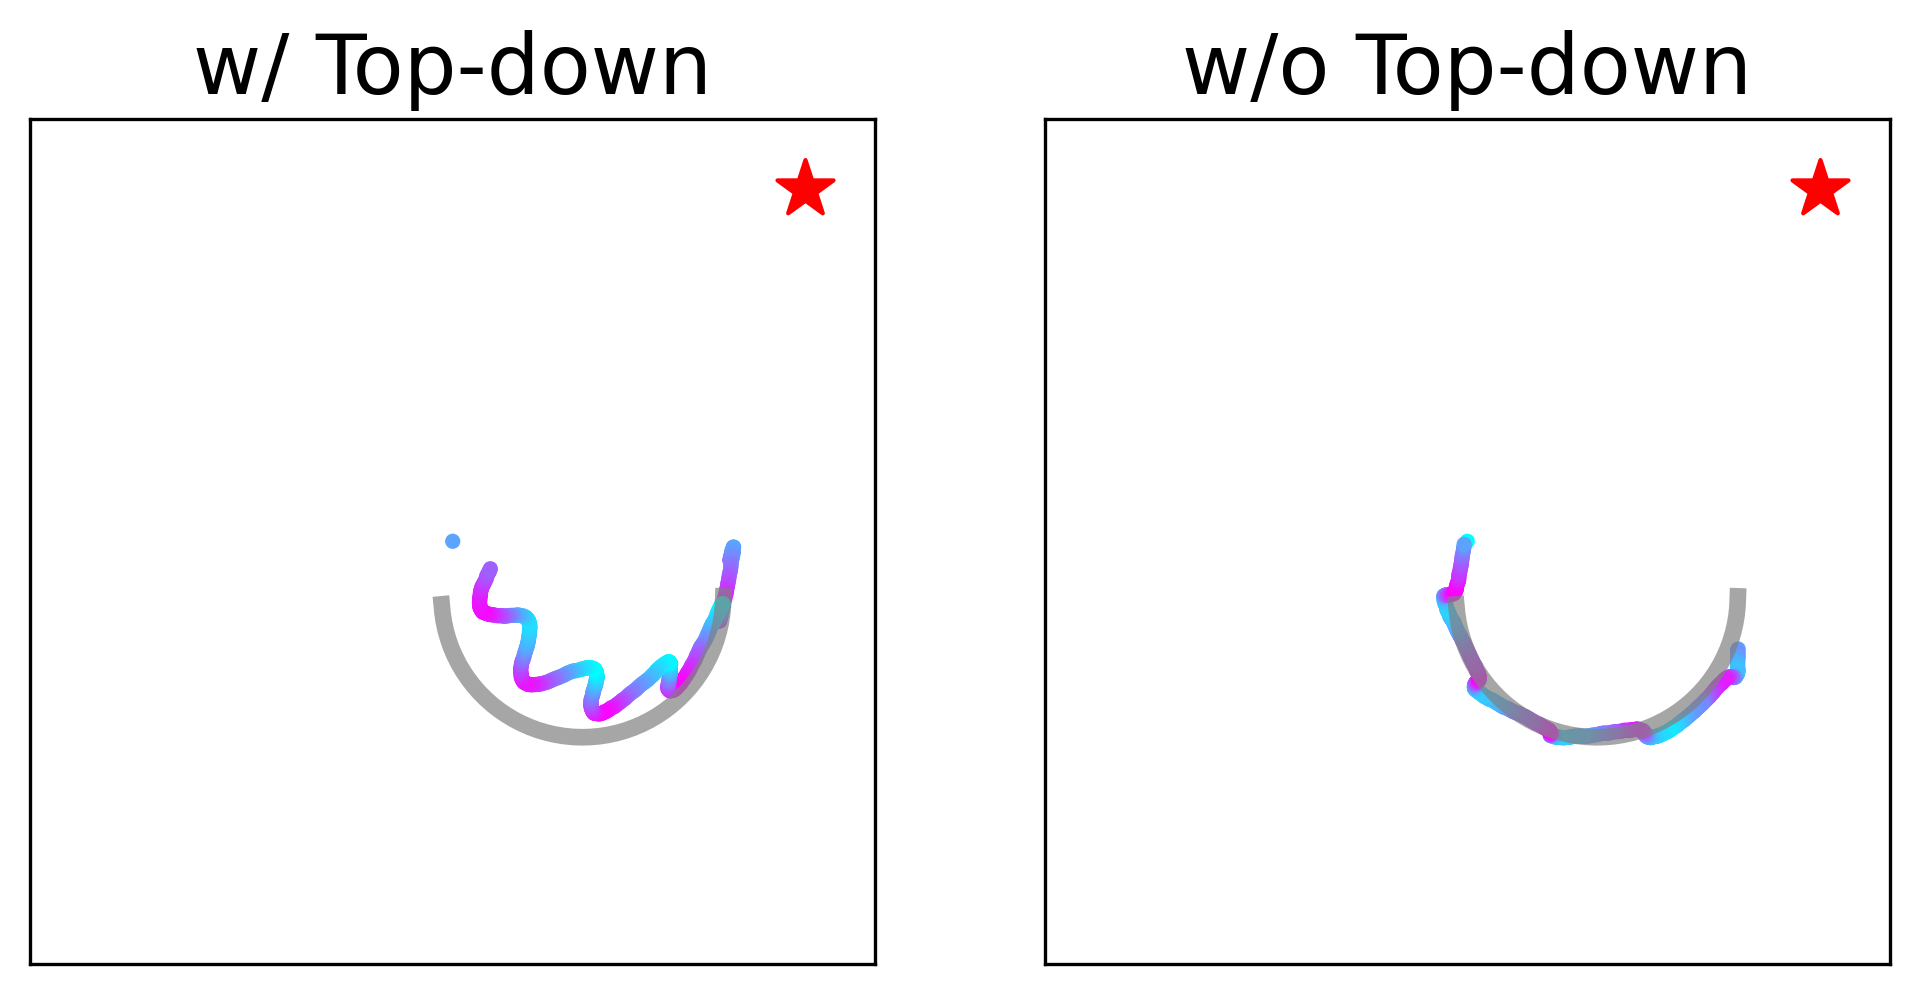

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), dpi=300)

max_r_grid = np.max(pc_activity_with_td, axis=(1,2)) 

ax[0].plot(
    animal_head_loc_all_with_td[:, 0], 
    animal_head_loc_all_with_td[:, 1], 
    color='grey', 
    linewidth=4.0, 
    label='Traj.', 
    alpha=0.7, 
)
ax[0].scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=200, label='Goal')

sc = ax[0].scatter(
                pc_bump_center_with_td[:, 0],
                pc_bump_center_with_td[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=7,
        )


#remove the ticks
ax[0].tick_params(axis='both', which='both', length=0)
#remove tick labels
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_aspect('equal')
ax[0].set_xlim(-0.6*np.pi,0.6*np.pi)
ax[0].set_ylim(-0.6*np.pi,0.6*np.pi)
# ax.set_title('w/o top-down', fontsize=8)
ax[0].set_title('w/ Top-down', fontsize=20)

max_r_grid = np.max(pc_activity_no_td, axis=(1,2)) 

ax[1].plot(
    animal_head_loc_all_no_td[:, 0], 
    animal_head_loc_all_no_td[:, 1], 
    color='grey', 
    linewidth=4.0, 
    label='Traj.', 
    alpha=0.7, 
)
ax[1].scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=200, label='Goal')

sc = ax[1].scatter(
                pc_bump_center_no_td[:, 0],
                pc_bump_center_no_td[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=7,
        )


#remove the ticks
ax[1].tick_params(axis='both', which='both', length=0)
#remove tick labels
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].set_aspect('equal')
ax[1].set_xlim(-0.6*np.pi,0.6*np.pi)
ax[1].set_ylim(-0.6*np.pi,0.6*np.pi)
# ax.set_title('w/o top-down', fontsize=8)
ax[1].set_title('w/o Top-down', fontsize=20)

plt.show()

In [15]:
# full-scale experiment

default_params_full_scale = copy.deepcopy(default_params)
default_params_full_scale["time_chunk"] = 100000
default_params_full_scale["total_time"] = 300
default_params_full_scale["move_prob"] = 0.9
default_params_full_scale["velocity"] = 15

default_params_full_scale["mbar_pc"] = 8.0
default_params_full_scale["theta_gc_modulation"] = 0.5

default_params_full_scale["a_pc"] = 0.7

default_params_full_scale["seed"] = 123

In [16]:
(
    HD_net_with_td, 
    PC_net_with_td,
    animal_centre_all_with_td,
    animal_head_loc_all_with_td,
    hd_all_with_td,
    md_all_with_td,
    gd_all_with_td,
    speed_all_with_td,
    velocity_all_with_td, 
    pc_activity_with_td,
    hd_activity_with_td,
    pc_bump_center_with_td,
    hd_bump_center_with_td,
    t_upsampled_with_td,
    theta_phase_with_td,
    theta_rhythm_with_td,
    rotation_phase_with_td,
    rotation_direction_flag_all_with_td,
) = run_model(
    **default_params_full_scale, 
)

default_params_no_td_full_scale = copy.deepcopy(default_params_full_scale)
default_params_no_td_full_scale["top_down"] = False
default_params_no_td_full_scale["animal_head_loc_all"] = animal_head_loc_all_with_td
default_params_no_td_full_scale["md_all"] = md_all_with_td
default_params_no_td_full_scale["speed_all"] = speed_all_with_td
default_params_no_td_full_scale["gd_all"] = gd_all_with_td

(
    HD_net_no_td, 
    PC_net_no_td,
    animal_centre_all_no_td,
    animal_head_loc_all_no_td,
    hd_all_no_td,
    md_all_no_td,
    gd_all_no_td,
    speed_all_no_td,
    velocity_all_no_td,
    pc_activity_no_td,
    hd_activity_no_td,
    pc_bump_center_no_td,
    hd_bump_center_no_td,
    t_upsampled_no_td,
    theta_phase_no_td,
    theta_rhythm_no_td,
    rotation_phase_no_td,
    rotation_direction_flag_all_no_td,
) = run_model(
    **default_params_no_td_full_scale, 
)

Start running simulation.
Simnulation progress: 0.0%
Simnulation progress: 33.3%
Simnulation progress: 66.7%
Simulation completed.
Start running simulation.
Simnulation progress: 0.0%
Simnulation progress: 33.3%
Simnulation progress: 66.7%
Simulation completed.


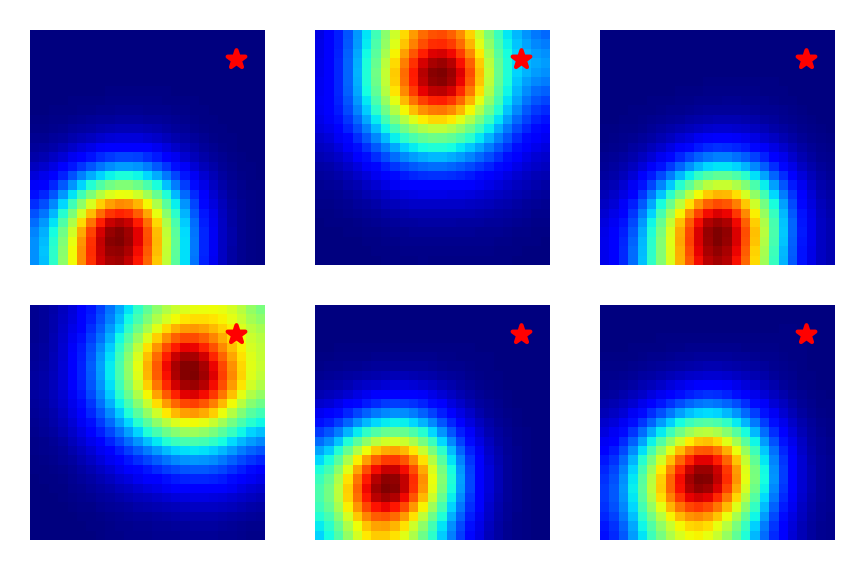

In [8]:

#plot all the firing rates in a single merged image

num = 50

fig, axs = plt.subplots(2, 3, figsize=(3,2), dpi=300)

dim = num//2
Position_norm = (animal_head_loc_all_with_td - animal_head_loc_all_with_td.min() - 1e-5)/(animal_head_loc_all_with_td.max() - animal_head_loc_all_with_td.min())
#mark the goal location
goal_x = (goal_loc[0]- animal_head_loc_all_with_td.min())/(animal_head_loc_all_with_td.max() - animal_head_loc_all_with_td.min())*dim
goal_y = (goal_loc[1]- animal_head_loc_all_with_td.min())/(animal_head_loc_all_with_td.max() - animal_head_loc_all_with_td.min())*dim

for i in range(6):
    cellindex_x = np.random.randint(12, 38)
    cellindex_y = np.random.randint(12, 38)
    map = get_tuningMap(pc_activity_with_td, 
                        Position_norm, 
                        cellindex_x=cellindex_x,
                        cellindex_y=cellindex_y,
                        filter= True,
                        samples_per_sec=1000,
                        dim=dim)
    
    #5 row and 2 cols
    ax = axs[i // 3, i % 3]

    ax.scatter(goal_x, goal_y, color='red', marker='*', s=20)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')  
    ax.imshow(map, cmap='jet', origin='lower')
    
    ax.grid(False)

plt.tight_layout()
# plt.savefig('figures/PaperFig/Example_place_maps.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()


In [9]:
import seaborn as sns
from scipy.signal import find_peaks
from matplotlib.colors import LinearSegmentedColormap

def create_custom_trajectory_cmap(target_color):
    """
    Create a colormap that transitions from white to the target color.

    Parameters
    ----------
    target_color : tuple or str
        A colour accepted by matplotlib (e.g., an RGB/RGBA tuple or a named string)

    Returns
    -------
    LinearSegmentedColormap
        A custom colormap object
    """
    return LinearSegmentedColormap.from_list('custom_cmap', ['white', target_color])


start = 15; end = 65 #extract a middle period as Changmin did in empirical data analysis. He used 15°-195° in 360°, so we used 15-65 in 100. 
num = 50
z_max = np.pi

#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase_with_td)
peaks -= 50 #get the trough!!! So that we plot the averaged sweeps like Changmin did in his lateset analysis where he used MUA
# troughs, _ = find_peaks(-theta_phase)       # for minima

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0])
ax.plot(theta_phase_with_td, color='black')
ax.scatter(peaks, theta_rhythm_with_td[peaks], color='#009FB9', s=20)
# ax.scatter(troughs, theta_rhythm[troughs], color='blue', s=20)
ax.set_xlim(0, 3000)
ax.set_ylim(np.min(theta_rhythm_with_td[:3000]), np.max(theta_rhythm_with_td[:3000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dimension as Angle_at_zeroPhase
BumpAngle_2_MD = []
BumpAngle_2_HD = []

BumpAngle_at_all_phase = []
BumpDist_2_pos = []
SweepLength = []
InitOffsetAngle2goal = []
InitOffsetDist = []
InitOffsetAngle2md = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - animal_head_loc_all_with_td[peaks[i], 0], goal_loc[1] - animal_head_loc_all_with_td[peaks[i], 1]])
    #calculate the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(velocity_all_with_td[peaks[i], 1], velocity_all_with_td[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bump_center_with_td[peaks[i]:peaks[i+1], :]       #/num * z_max
    
    #using 20th point as initial offset
    init_offset_loc = bumpTraj_in_Acycle[start,:]
    #calculate the vect from offset loc to position 
    init_offset_vec = np.array([init_offset_loc[0] - animal_head_loc_all_with_td[peaks[i]+start, 0], init_offset_loc[1] - animal_head_loc_all_with_td[peaks[i]+start, 1]])
    #init offset dist
    int_offset_dist = np.linalg.norm(init_offset_vec)
    InitOffsetDist.append(int_offset_dist)
    
    #calculate the angle between offset_vec and direction to goal
    init_offset_angle = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(vec[1], vec[0])
    #wrap to 0-360
    init_offset_angle = np.degrees(init_offset_angle) % 360
    #change to radians
    init_offset_angle = np.radians(init_offset_angle)
    #append to InitOffsetAngle2goal
    InitOffsetAngle2goal.append(init_offset_angle)
    
    #calculate the angle between offset_vec and moving direction
    init_offset_angle2md = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(velocity_all_with_td[peaks[i], 1], velocity_all_with_td[peaks[i], 0])
    #wrap to 0-360
    init_offset_angle2md = np.degrees(init_offset_angle2md) % 360
    #chnage to radians
    init_offset_angle2md = np.radians(init_offset_angle2md)
    InitOffsetAngle2md.append(init_offset_angle2md)    
        
    # sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
    # sweep_length = np.linalg.norm(Animal_location_all[peaks[i], :] - bumpTraj_in_Acycle[end,:])
    
    # start_point = bumpTraj_in_Acycle[start, :]
    # # start_point = Animal_location_all[peaks[i], :]
    # distances = np.linalg.norm(bumpTraj_in_Acycle - start_point, axis=1)
    # sweep_length = np.max(distances)

    pos_in_Acycle = animal_head_loc_all_with_td[peaks[i]:peaks[i+1], :]
    # start_point = Animal_location_all[peaks[i], :]
    distances = np.linalg.norm(bumpTraj_in_Acycle - pos_in_Acycle, axis=1)
    sweep_length = np.max(distances) - np.min(distances)  # Calculate the range of distances
    
    SweepLength.append(sweep_length)
    
    BumpAngle = []
    BumpDist = []
    
    # for j in range(len(bumpTraj_in_Acycle)):
    for j in range(start, end):
        pos2goal_vec = np.array([goal_loc[0] - pos_in_Acycle[j, 0], goal_loc[1] - pos_in_Acycle[j, 1]])
        #calculate sweep direction relative to position
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - pos_in_Acycle[j, 0], bumpTraj_in_Acycle[j, 1] - pos_in_Acycle[j, 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(pos2goal_vec[1], pos2goal_vec[0])
        angle2 = np.degrees(angle2) % 360
        angle2 = np.radians(angle2)  # Convert to radians
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(velocity_all_with_td[peaks[i]+j, 1], velocity_all_with_td[peaks[i]+j, 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        angle3 = np.radians(angle3)  # Convert to radians
        BumpAngle_2_MD.append(angle3)
        
        #calculate the angle betweens sweeps and head direction
        HD_vec = np.array([np.cos(hd_all_with_td[peaks[i]+j]), np.sin(hd_all_with_td[peaks[i]+j])])
        angle4 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(HD_vec[1], HD_vec[0])
        angle4 = np.degrees(angle4) % 360
        angle4 = np.radians(angle4)  # Convert to radians
        BumpAngle_2_HD.append(angle4)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

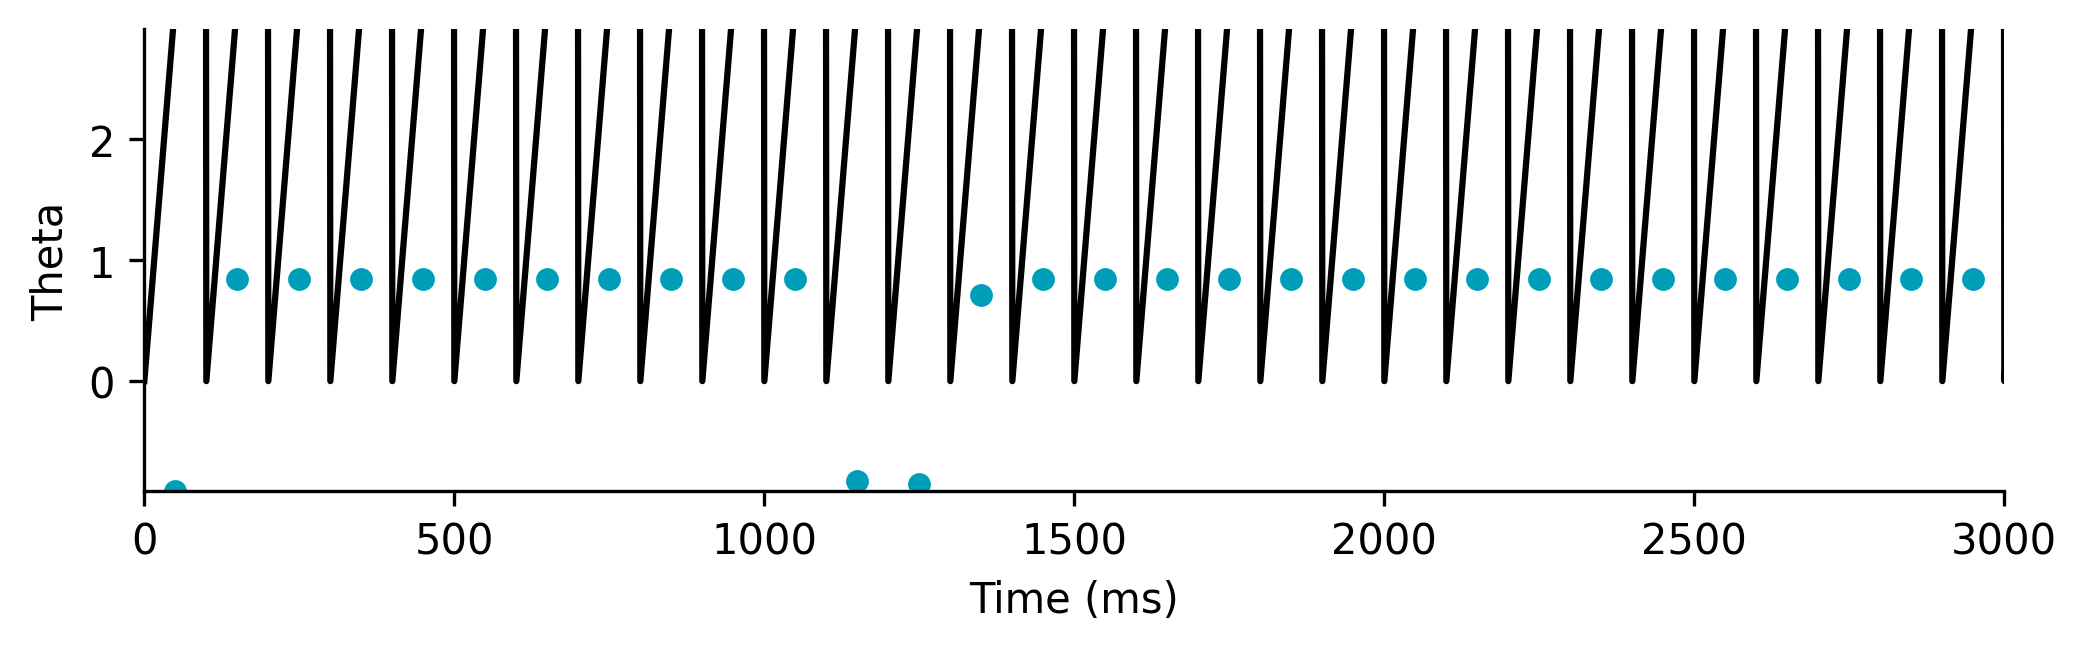

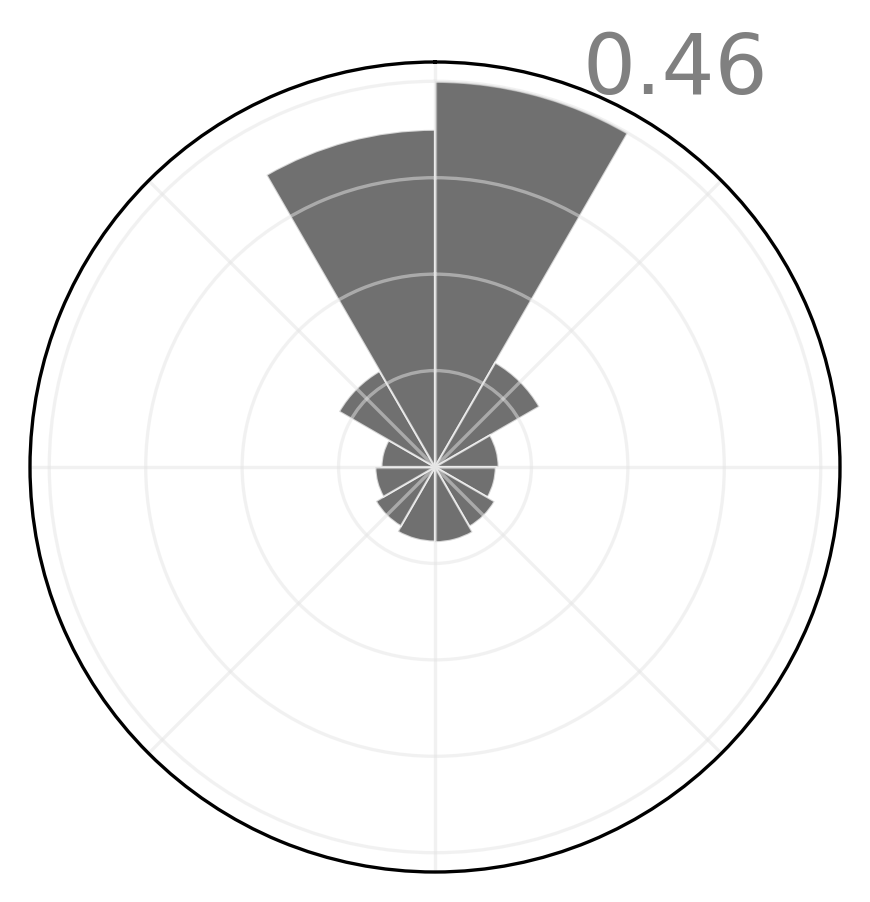

In [10]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#333333',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

bins = np.linspace(0, 2*np.pi, 36)

plot_circular_histogram(
    np.array(BumpAngle_2_goal), 
    bins=12, 
    density=True, 
    ax=ax, 
    colors=colors, 
    fontsize=20, 
    show_xlabels=False, 
)

# ax.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
# ax0.set_title('S.D. vs G.D.', fontsize=8)

# fig.savefig('figures/PaperFig/theta_sweep_sd_vs_gd.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

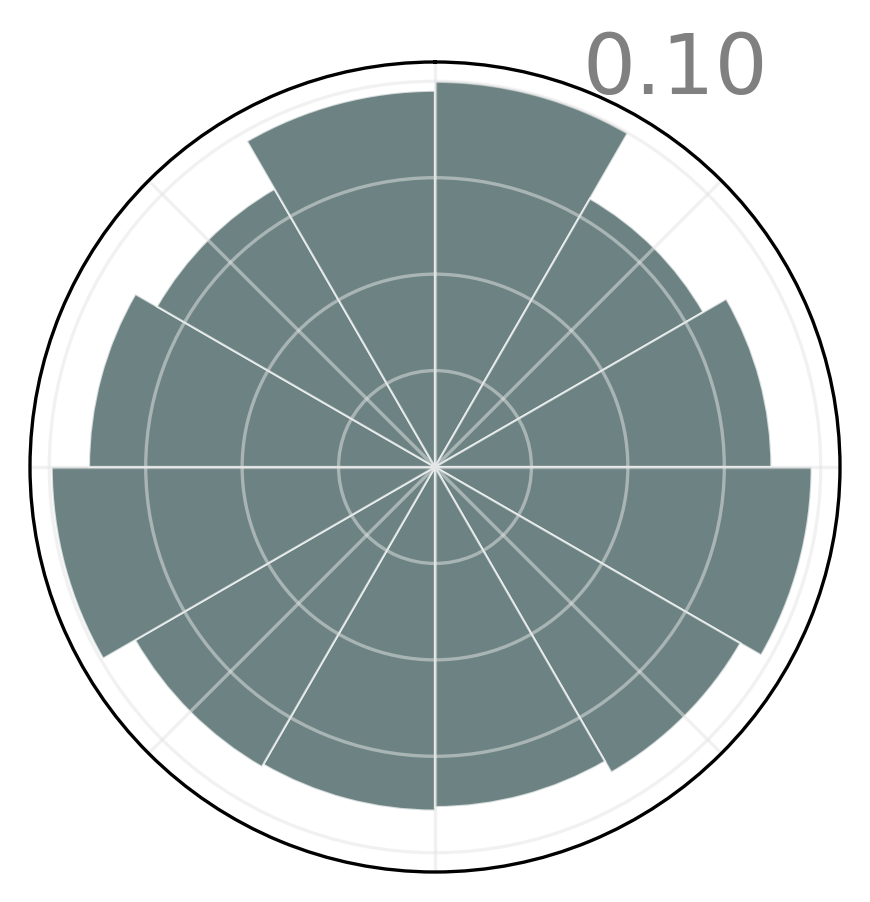

In [11]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#2F4F4F',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

bins = np.linspace(0, 2*np.pi, 36)

plot_circular_histogram(
    np.array(BumpAngle_2_MD), 
    bins=12, 
    density=True, 
    ax=ax, 
    colors=colors, 
    fontsize=20, 
    show_xlabels=False, 
)

# ax.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
# ax0.set_title('S.D. vs G.D.', fontsize=8)

# fig.savefig('figures/PaperFig/theta_sweep_sd_vs_md.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

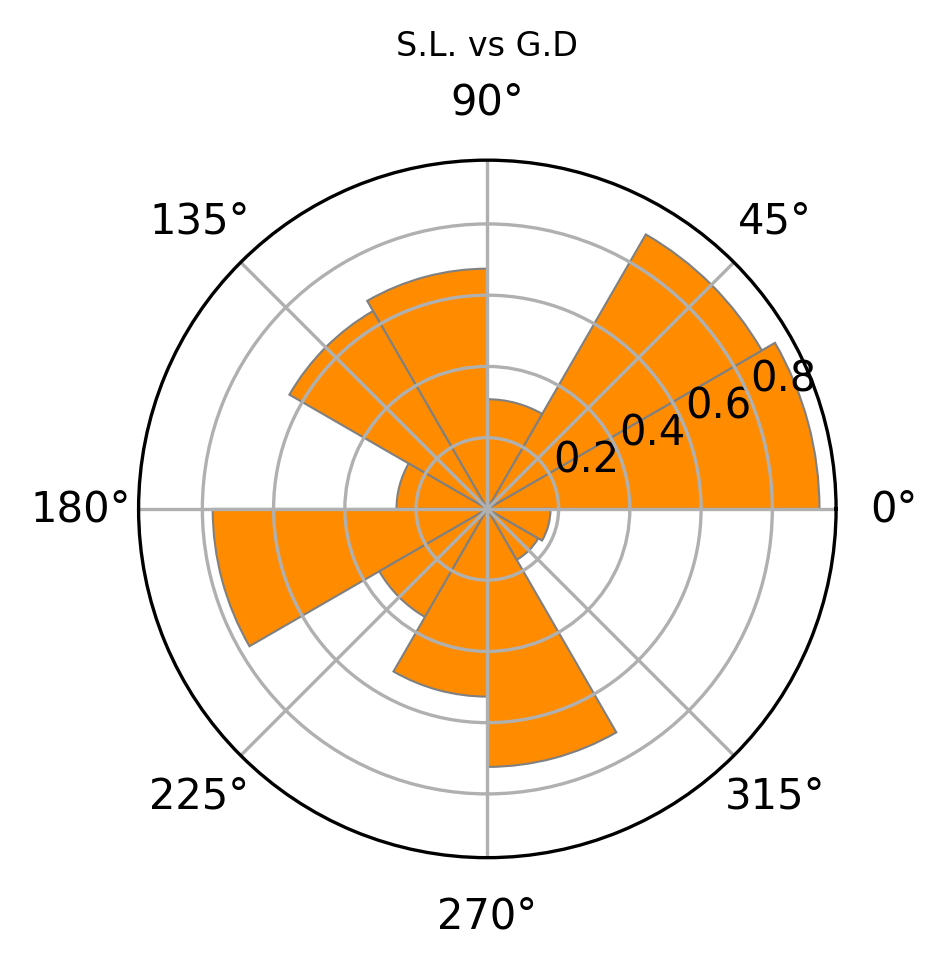

In [14]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#7B3B89',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

n_bins = 12
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

mean_sweep_length = np.zeros(n_bins)
for i in range(n_bins):
    # Get the indices of the sweeps that fall into the current bin
    indices = np.where((np.array(Angle_at_zeroPhase) >= bin_edges[i]) & (np.array(Angle_at_zeroPhase) < bin_edges[i + 1]))[0]
    if len(indices) > 0:
        mean_sweep_length[i] = np.mean(np.array(SweepLength)[indices])
    else:
        mean_sweep_length[i] = 0

# plot_circular_histogram_with_values(
#     fig, 
#     ax, 
#     mean_sweep_length, 
#     bins=bin_edges, 
#     colors=colors, 
#     fontsize=20,
#     normalize=False, 
# )

# Prepare angles for bar centres
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as polar histogram (bar plot)
ax.bar(bin_centres, mean_sweep_length, width=(2 * np.pi / n_bins), bottom=0.0, color='darkorange', edgecolor='grey', linewidth=0.5)

ax.set_title('S.L. vs G.D', fontsize=8)
plt.show()

In [ ]:
ax5 = plt.subplot(gs[1, 2], projection='polar') 
ax5.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
# Convert angles to radians in range [0, 2π)
angles_rad = np.radians(np.array(Angle_at_zeroPhase) % 360)
sweep_lengths = np.array(SweepLength)

# Define bin edges (72 bins of 5 degrees)
n_bins = 18
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

# Digitise the angle data into bins
bin_indices = np.digitize(angles_rad, bin_edges) - 1  # subtract 1 to make indices 0-based

# Initialise array to store average sweep lengths
avg_sweep_length = np.zeros(n_bins)
for i in range(n_bins):
    in_bin = sweep_lengths[bin_indices == i]
    if len(in_bin) > 0:
        avg_sweep_length[i] = np.mean(in_bin)
    else:
        avg_sweep_length[i] = 0.0  # or np.nan if you prefer

# Prepare angles for bar centres
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as polar histogram (bar plot)
ax5.bar(bin_centres, avg_sweep_length, width=(2 * np.pi / n_bins), bottom=0.0, color='darkorange', edgecolor='grey', linewidth=0.5)

ax5.set_title('S.L. vs G.D', fontsize=8)